In [3]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using mps device


In [5]:
if torch.backends.mps.is_available():
    print("MPS backend is available.")
else:
    print("MPS backend is not available. Using CPU instead.")
    

MPS backend is available.


In [6]:
import os
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, v2
import numpy as np
from collections import defaultdict
# Data preprocessde data augementation yapalım.
# Albumentations
#Transformalara çak
# Transformları tanımlayalım
transform = v2.Compose([
      v2.RandomResizedCrop(size=(224, 224), antialias=True),
      v2.RandomHorizontalFlip(p=0.5),
      v2.ToImage(), 
      v2.ToDtype(torch.float32, scale=True),
      
      v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
    ,
])

# Veri setini yükleme
dataset = datasets.ImageFolder(root="/Users/mehdiarat/Downloads/archive/animal_computer_vision/Dataset", transform=transform)

# Sınıfları ve indeksleri ayırma
class_indices = defaultdict(list)
for idx, (_, label) in enumerate(dataset.samples):
    class_indices[label].append(idx)

# Her sınıftan aynı sayıda veri seçme (örneğin, her sınıftan 100 örnek)
n_samples_per_class = min(len(indices) for indices in class_indices.values())
selected_train_indices = []
selected_val_indices = []

# Eğitim ve doğrulama seti için veri seçme
for indices in class_indices.values():
    np.random.shuffle(indices)
    split = int(n_samples_per_class * 0.8)  # %80 eğitim, %20 doğrulama
    selected_train_indices.extend(indices[:split])
    selected_val_indices.extend(indices[split:n_samples_per_class])

# Subset'ler oluşturma
train_dataset = Subset(dataset, selected_train_indices)
val_dataset = Subset(dataset, selected_val_indices)

# DataLoader ile veri setlerini yükleme
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Eğitim seti sınıf dağılımını kontrol etme
train_labels = [label for _, label in Subset(dataset, selected_train_indices)]
val_labels = [label for _, label in Subset(dataset, selected_val_indices)]

print("Training set class distribution:", {label: train_labels.count(label) for label in set(train_labels)})
print("Validation set class distribution:", {label: val_labels.count(label) for label in set(val_labels)})

Training set class distribution: {0: 800, 1: 800, 2: 800, 3: 800}
Validation set class distribution: {0: 200, 1: 200, 2: 200, 3: 200}


In [7]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)  # 128 feature maps from 28x28 image size
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1) # Flattening the tensor
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Sınıf sayısını belirleyelim
num_classes = len(dataset.classes)
model2 = SimpleCNN(num_classes=num_classes)

In [38]:
import torch.optim as optim

# Cihazı ayarlama (GPU kullanılıyorsa)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = model2.to(device)

# Loss function ve optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)

In [43]:
# Eğitim döngüsü
num_epochs = 15  # Eğitim için epoch sayısı

for epoch in range(num_epochs):
    model2.train()
    running_loss = 0.0
    
    for i, (images, labels) in enumerate(train_loader, 1):  # `i` now counts the batch number
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model2(images)
        loss = criterion(outputs, labels)

        # Backward pass ve optimizasyon
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        # Batch doğruluğunu hesaplama
        _, predicted = torch.max(outputs, 1)
        correct_predictions = (predicted == labels).sum().item()
        batch_accuracy = 100 * correct_predictions / labels.size(0)
        
        # Her batch için loss ve accuracy'yi yazdırma
        print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i}/{len(train_loader)}], Batch Loss: {loss.item():.4f}, Batch Accuracy: {batch_accuracy:.2f}%')

    # Epoch sonu loss hesaplama
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch + 1}/{num_epochs} completed, Loss: {epoch_loss:.4f}')

    # Doğrulama seti üzerinde performans kontrolü
    model2.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model2(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Validation Accuracy: {accuracy:.2f}%')

print('Training complete')

Epoch [1/15], Step [1/100], Batch Loss: 1.3785, Batch Accuracy: 28.12%
Epoch [1/15], Step [2/100], Batch Loss: 15.4512, Batch Accuracy: 25.00%
Epoch [1/15], Step [3/100], Batch Loss: 4.8914, Batch Accuracy: 25.00%
Epoch [1/15], Step [4/100], Batch Loss: 2.2531, Batch Accuracy: 31.25%
Epoch [1/15], Step [5/100], Batch Loss: 1.8046, Batch Accuracy: 18.75%
Epoch [1/15], Step [6/100], Batch Loss: 1.4914, Batch Accuracy: 12.50%
Epoch [1/15], Step [7/100], Batch Loss: 1.3691, Batch Accuracy: 28.12%
Epoch [1/15], Step [8/100], Batch Loss: 1.3745, Batch Accuracy: 21.88%
Epoch [1/15], Step [9/100], Batch Loss: 1.3583, Batch Accuracy: 28.12%
Epoch [1/15], Step [10/100], Batch Loss: 1.4833, Batch Accuracy: 21.88%
Epoch [1/15], Step [11/100], Batch Loss: 1.4467, Batch Accuracy: 18.75%
Epoch [1/15], Step [12/100], Batch Loss: 1.3778, Batch Accuracy: 28.12%
Epoch [1/15], Step [13/100], Batch Loss: 1.3498, Batch Accuracy: 43.75%
Epoch [1/15], Step [14/100], Batch Loss: 1.3697, Batch Accuracy: 34.38%


Epoch [2/15], Step [15/100], Batch Loss: 1.0099, Batch Accuracy: 59.38%
Epoch [2/15], Step [16/100], Batch Loss: 1.2162, Batch Accuracy: 46.88%
Epoch [2/15], Step [17/100], Batch Loss: 1.0136, Batch Accuracy: 56.25%
Epoch [2/15], Step [18/100], Batch Loss: 1.0475, Batch Accuracy: 43.75%
Epoch [2/15], Step [19/100], Batch Loss: 0.9166, Batch Accuracy: 56.25%
Epoch [2/15], Step [20/100], Batch Loss: 0.8719, Batch Accuracy: 62.50%
Epoch [2/15], Step [21/100], Batch Loss: 0.9868, Batch Accuracy: 56.25%
Epoch [2/15], Step [22/100], Batch Loss: 1.0083, Batch Accuracy: 50.00%
Epoch [2/15], Step [23/100], Batch Loss: 0.8981, Batch Accuracy: 50.00%
Epoch [2/15], Step [24/100], Batch Loss: 0.9926, Batch Accuracy: 46.88%
Epoch [2/15], Step [25/100], Batch Loss: 0.9532, Batch Accuracy: 50.00%
Epoch [2/15], Step [26/100], Batch Loss: 1.2592, Batch Accuracy: 34.38%
Epoch [2/15], Step [27/100], Batch Loss: 0.9448, Batch Accuracy: 71.88%
Epoch [2/15], Step [28/100], Batch Loss: 0.9153, Batch Accuracy:

Epoch [3/15], Step [29/100], Batch Loss: 1.0161, Batch Accuracy: 50.00%
Epoch [3/15], Step [30/100], Batch Loss: 1.0159, Batch Accuracy: 50.00%
Epoch [3/15], Step [31/100], Batch Loss: 0.9056, Batch Accuracy: 56.25%
Epoch [3/15], Step [32/100], Batch Loss: 0.9020, Batch Accuracy: 56.25%
Epoch [3/15], Step [33/100], Batch Loss: 0.7887, Batch Accuracy: 65.62%
Epoch [3/15], Step [34/100], Batch Loss: 1.0436, Batch Accuracy: 56.25%
Epoch [3/15], Step [35/100], Batch Loss: 0.9147, Batch Accuracy: 68.75%
Epoch [3/15], Step [36/100], Batch Loss: 0.8501, Batch Accuracy: 65.62%
Epoch [3/15], Step [37/100], Batch Loss: 1.1242, Batch Accuracy: 56.25%
Epoch [3/15], Step [38/100], Batch Loss: 1.0762, Batch Accuracy: 43.75%
Epoch [3/15], Step [39/100], Batch Loss: 0.8457, Batch Accuracy: 59.38%
Epoch [3/15], Step [40/100], Batch Loss: 0.9168, Batch Accuracy: 53.12%
Epoch [3/15], Step [41/100], Batch Loss: 1.1083, Batch Accuracy: 37.50%
Epoch [3/15], Step [42/100], Batch Loss: 0.9972, Batch Accuracy:

Epoch [4/15], Step [43/100], Batch Loss: 0.8348, Batch Accuracy: 75.00%
Epoch [4/15], Step [44/100], Batch Loss: 0.8366, Batch Accuracy: 62.50%
Epoch [4/15], Step [45/100], Batch Loss: 0.8938, Batch Accuracy: 59.38%
Epoch [4/15], Step [46/100], Batch Loss: 0.8654, Batch Accuracy: 59.38%
Epoch [4/15], Step [47/100], Batch Loss: 1.0112, Batch Accuracy: 43.75%
Epoch [4/15], Step [48/100], Batch Loss: 0.8394, Batch Accuracy: 65.62%
Epoch [4/15], Step [49/100], Batch Loss: 0.8342, Batch Accuracy: 71.88%
Epoch [4/15], Step [50/100], Batch Loss: 0.8224, Batch Accuracy: 56.25%
Epoch [4/15], Step [51/100], Batch Loss: 0.8330, Batch Accuracy: 62.50%
Epoch [4/15], Step [52/100], Batch Loss: 0.8807, Batch Accuracy: 56.25%
Epoch [4/15], Step [53/100], Batch Loss: 0.9047, Batch Accuracy: 56.25%
Epoch [4/15], Step [54/100], Batch Loss: 0.7487, Batch Accuracy: 68.75%
Epoch [4/15], Step [55/100], Batch Loss: 0.8551, Batch Accuracy: 68.75%
Epoch [4/15], Step [56/100], Batch Loss: 0.7846, Batch Accuracy:

Epoch [5/15], Step [57/100], Batch Loss: 1.0095, Batch Accuracy: 50.00%
Epoch [5/15], Step [58/100], Batch Loss: 0.8987, Batch Accuracy: 59.38%
Epoch [5/15], Step [59/100], Batch Loss: 0.5405, Batch Accuracy: 75.00%
Epoch [5/15], Step [60/100], Batch Loss: 1.0010, Batch Accuracy: 56.25%
Epoch [5/15], Step [61/100], Batch Loss: 1.0964, Batch Accuracy: 46.88%
Epoch [5/15], Step [62/100], Batch Loss: 0.9269, Batch Accuracy: 56.25%
Epoch [5/15], Step [63/100], Batch Loss: 1.0174, Batch Accuracy: 56.25%
Epoch [5/15], Step [64/100], Batch Loss: 0.8438, Batch Accuracy: 59.38%
Epoch [5/15], Step [65/100], Batch Loss: 0.9403, Batch Accuracy: 62.50%
Epoch [5/15], Step [66/100], Batch Loss: 0.7586, Batch Accuracy: 56.25%
Epoch [5/15], Step [67/100], Batch Loss: 0.9080, Batch Accuracy: 56.25%
Epoch [5/15], Step [68/100], Batch Loss: 0.8414, Batch Accuracy: 62.50%
Epoch [5/15], Step [69/100], Batch Loss: 0.8191, Batch Accuracy: 71.88%
Epoch [5/15], Step [70/100], Batch Loss: 0.7006, Batch Accuracy:

Epoch [6/15], Step [71/100], Batch Loss: 0.9903, Batch Accuracy: 53.12%
Epoch [6/15], Step [72/100], Batch Loss: 0.7750, Batch Accuracy: 68.75%
Epoch [6/15], Step [73/100], Batch Loss: 0.8613, Batch Accuracy: 68.75%
Epoch [6/15], Step [74/100], Batch Loss: 0.8474, Batch Accuracy: 65.62%
Epoch [6/15], Step [75/100], Batch Loss: 0.7339, Batch Accuracy: 62.50%
Epoch [6/15], Step [76/100], Batch Loss: 0.7122, Batch Accuracy: 68.75%
Epoch [6/15], Step [77/100], Batch Loss: 0.7221, Batch Accuracy: 75.00%
Epoch [6/15], Step [78/100], Batch Loss: 0.9486, Batch Accuracy: 56.25%
Epoch [6/15], Step [79/100], Batch Loss: 0.8874, Batch Accuracy: 50.00%
Epoch [6/15], Step [80/100], Batch Loss: 0.8467, Batch Accuracy: 62.50%
Epoch [6/15], Step [81/100], Batch Loss: 0.7393, Batch Accuracy: 71.88%
Epoch [6/15], Step [82/100], Batch Loss: 0.5300, Batch Accuracy: 71.88%
Epoch [6/15], Step [83/100], Batch Loss: 0.8106, Batch Accuracy: 62.50%
Epoch [6/15], Step [84/100], Batch Loss: 0.9377, Batch Accuracy:

Epoch [7/15], Step [85/100], Batch Loss: 0.7081, Batch Accuracy: 75.00%
Epoch [7/15], Step [86/100], Batch Loss: 0.7972, Batch Accuracy: 59.38%
Epoch [7/15], Step [87/100], Batch Loss: 0.8431, Batch Accuracy: 68.75%
Epoch [7/15], Step [88/100], Batch Loss: 0.6442, Batch Accuracy: 71.88%
Epoch [7/15], Step [89/100], Batch Loss: 0.8333, Batch Accuracy: 56.25%
Epoch [7/15], Step [90/100], Batch Loss: 0.9121, Batch Accuracy: 56.25%
Epoch [7/15], Step [91/100], Batch Loss: 0.8475, Batch Accuracy: 71.88%
Epoch [7/15], Step [92/100], Batch Loss: 0.7412, Batch Accuracy: 71.88%
Epoch [7/15], Step [93/100], Batch Loss: 0.8274, Batch Accuracy: 75.00%
Epoch [7/15], Step [94/100], Batch Loss: 0.6686, Batch Accuracy: 68.75%
Epoch [7/15], Step [95/100], Batch Loss: 0.9077, Batch Accuracy: 59.38%
Epoch [7/15], Step [96/100], Batch Loss: 0.8576, Batch Accuracy: 56.25%
Epoch [7/15], Step [97/100], Batch Loss: 0.6512, Batch Accuracy: 81.25%
Epoch [7/15], Step [98/100], Batch Loss: 0.6913, Batch Accuracy:

Epoch [8/15], Step [99/100], Batch Loss: 0.7712, Batch Accuracy: 68.75%
Epoch [8/15], Step [100/100], Batch Loss: 0.8514, Batch Accuracy: 65.62%
Epoch 8/15 completed, Loss: 0.7701
Validation Accuracy: 66.88%
Epoch [9/15], Step [1/100], Batch Loss: 0.6795, Batch Accuracy: 68.75%
Epoch [9/15], Step [2/100], Batch Loss: 0.5482, Batch Accuracy: 84.38%
Epoch [9/15], Step [3/100], Batch Loss: 0.4766, Batch Accuracy: 78.12%
Epoch [9/15], Step [4/100], Batch Loss: 0.9661, Batch Accuracy: 53.12%
Epoch [9/15], Step [5/100], Batch Loss: 0.4803, Batch Accuracy: 81.25%
Epoch [9/15], Step [6/100], Batch Loss: 1.0933, Batch Accuracy: 71.88%
Epoch [9/15], Step [7/100], Batch Loss: 0.6116, Batch Accuracy: 65.62%
Epoch [9/15], Step [8/100], Batch Loss: 0.8021, Batch Accuracy: 59.38%
Epoch [9/15], Step [9/100], Batch Loss: 0.7023, Batch Accuracy: 78.12%
Epoch [9/15], Step [10/100], Batch Loss: 0.7172, Batch Accuracy: 87.50%
Epoch [9/15], Step [11/100], Batch Loss: 0.4663, Batch Accuracy: 87.50%
Epoch [9/

Epoch [10/15], Step [12/100], Batch Loss: 0.6479, Batch Accuracy: 78.12%
Epoch [10/15], Step [13/100], Batch Loss: 0.8174, Batch Accuracy: 68.75%
Epoch [10/15], Step [14/100], Batch Loss: 0.8151, Batch Accuracy: 68.75%
Epoch [10/15], Step [15/100], Batch Loss: 0.8538, Batch Accuracy: 59.38%
Epoch [10/15], Step [16/100], Batch Loss: 0.6853, Batch Accuracy: 68.75%
Epoch [10/15], Step [17/100], Batch Loss: 0.7182, Batch Accuracy: 71.88%
Epoch [10/15], Step [18/100], Batch Loss: 0.7922, Batch Accuracy: 71.88%
Epoch [10/15], Step [19/100], Batch Loss: 0.8024, Batch Accuracy: 53.12%
Epoch [10/15], Step [20/100], Batch Loss: 0.6838, Batch Accuracy: 75.00%
Epoch [10/15], Step [21/100], Batch Loss: 0.8112, Batch Accuracy: 65.62%
Epoch [10/15], Step [22/100], Batch Loss: 0.8104, Batch Accuracy: 71.88%
Epoch [10/15], Step [23/100], Batch Loss: 0.6126, Batch Accuracy: 75.00%
Epoch [10/15], Step [24/100], Batch Loss: 0.4398, Batch Accuracy: 87.50%
Epoch [10/15], Step [25/100], Batch Loss: 0.8215, B

Epoch [11/15], Step [24/100], Batch Loss: 0.6385, Batch Accuracy: 68.75%
Epoch [11/15], Step [25/100], Batch Loss: 0.9990, Batch Accuracy: 56.25%
Epoch [11/15], Step [26/100], Batch Loss: 0.8807, Batch Accuracy: 68.75%
Epoch [11/15], Step [27/100], Batch Loss: 0.6810, Batch Accuracy: 78.12%
Epoch [11/15], Step [28/100], Batch Loss: 0.7080, Batch Accuracy: 68.75%
Epoch [11/15], Step [29/100], Batch Loss: 0.7769, Batch Accuracy: 68.75%
Epoch [11/15], Step [30/100], Batch Loss: 0.9859, Batch Accuracy: 59.38%
Epoch [11/15], Step [31/100], Batch Loss: 0.6579, Batch Accuracy: 71.88%
Epoch [11/15], Step [32/100], Batch Loss: 0.6605, Batch Accuracy: 75.00%
Epoch [11/15], Step [33/100], Batch Loss: 0.7072, Batch Accuracy: 71.88%
Epoch [11/15], Step [34/100], Batch Loss: 0.6185, Batch Accuracy: 68.75%
Epoch [11/15], Step [35/100], Batch Loss: 0.7141, Batch Accuracy: 71.88%
Epoch [11/15], Step [36/100], Batch Loss: 0.6235, Batch Accuracy: 68.75%
Epoch [11/15], Step [37/100], Batch Loss: 0.5639, B

Epoch [12/15], Step [36/100], Batch Loss: 0.6249, Batch Accuracy: 75.00%
Epoch [12/15], Step [37/100], Batch Loss: 0.5795, Batch Accuracy: 75.00%
Epoch [12/15], Step [38/100], Batch Loss: 0.4103, Batch Accuracy: 78.12%
Epoch [12/15], Step [39/100], Batch Loss: 0.6512, Batch Accuracy: 71.88%
Epoch [12/15], Step [40/100], Batch Loss: 0.8307, Batch Accuracy: 53.12%
Epoch [12/15], Step [41/100], Batch Loss: 0.6240, Batch Accuracy: 78.12%
Epoch [12/15], Step [42/100], Batch Loss: 0.4422, Batch Accuracy: 90.62%
Epoch [12/15], Step [43/100], Batch Loss: 0.5310, Batch Accuracy: 84.38%
Epoch [12/15], Step [44/100], Batch Loss: 0.5307, Batch Accuracy: 68.75%
Epoch [12/15], Step [45/100], Batch Loss: 0.7184, Batch Accuracy: 68.75%
Epoch [12/15], Step [46/100], Batch Loss: 0.5228, Batch Accuracy: 81.25%
Epoch [12/15], Step [47/100], Batch Loss: 1.0691, Batch Accuracy: 56.25%
Epoch [12/15], Step [48/100], Batch Loss: 0.7852, Batch Accuracy: 59.38%
Epoch [12/15], Step [49/100], Batch Loss: 0.5095, B

Epoch [13/15], Step [48/100], Batch Loss: 0.6934, Batch Accuracy: 75.00%
Epoch [13/15], Step [49/100], Batch Loss: 0.6010, Batch Accuracy: 71.88%
Epoch [13/15], Step [50/100], Batch Loss: 0.5977, Batch Accuracy: 75.00%
Epoch [13/15], Step [51/100], Batch Loss: 0.6636, Batch Accuracy: 75.00%
Epoch [13/15], Step [52/100], Batch Loss: 0.5775, Batch Accuracy: 81.25%
Epoch [13/15], Step [53/100], Batch Loss: 0.5109, Batch Accuracy: 78.12%
Epoch [13/15], Step [54/100], Batch Loss: 0.5812, Batch Accuracy: 75.00%
Epoch [13/15], Step [55/100], Batch Loss: 0.6972, Batch Accuracy: 75.00%
Epoch [13/15], Step [56/100], Batch Loss: 0.6120, Batch Accuracy: 78.12%
Epoch [13/15], Step [57/100], Batch Loss: 0.7823, Batch Accuracy: 65.62%
Epoch [13/15], Step [58/100], Batch Loss: 0.9272, Batch Accuracy: 59.38%
Epoch [13/15], Step [59/100], Batch Loss: 0.7824, Batch Accuracy: 59.38%
Epoch [13/15], Step [60/100], Batch Loss: 1.0089, Batch Accuracy: 59.38%
Epoch [13/15], Step [61/100], Batch Loss: 0.4892, B

Epoch [14/15], Step [60/100], Batch Loss: 0.6967, Batch Accuracy: 62.50%
Epoch [14/15], Step [61/100], Batch Loss: 0.4240, Batch Accuracy: 78.12%
Epoch [14/15], Step [62/100], Batch Loss: 0.6706, Batch Accuracy: 71.88%
Epoch [14/15], Step [63/100], Batch Loss: 0.6854, Batch Accuracy: 68.75%
Epoch [14/15], Step [64/100], Batch Loss: 0.5906, Batch Accuracy: 71.88%
Epoch [14/15], Step [65/100], Batch Loss: 0.7955, Batch Accuracy: 59.38%
Epoch [14/15], Step [66/100], Batch Loss: 0.6290, Batch Accuracy: 68.75%
Epoch [14/15], Step [67/100], Batch Loss: 0.6810, Batch Accuracy: 81.25%
Epoch [14/15], Step [68/100], Batch Loss: 0.6666, Batch Accuracy: 71.88%
Epoch [14/15], Step [69/100], Batch Loss: 0.4725, Batch Accuracy: 78.12%
Epoch [14/15], Step [70/100], Batch Loss: 0.6736, Batch Accuracy: 65.62%
Epoch [14/15], Step [71/100], Batch Loss: 0.7345, Batch Accuracy: 65.62%
Epoch [14/15], Step [72/100], Batch Loss: 0.8448, Batch Accuracy: 59.38%
Epoch [14/15], Step [73/100], Batch Loss: 0.5542, B

Epoch [15/15], Step [72/100], Batch Loss: 0.4852, Batch Accuracy: 81.25%
Epoch [15/15], Step [73/100], Batch Loss: 0.4187, Batch Accuracy: 84.38%
Epoch [15/15], Step [74/100], Batch Loss: 0.7489, Batch Accuracy: 65.62%
Epoch [15/15], Step [75/100], Batch Loss: 0.8089, Batch Accuracy: 62.50%
Epoch [15/15], Step [76/100], Batch Loss: 0.4246, Batch Accuracy: 84.38%
Epoch [15/15], Step [77/100], Batch Loss: 0.6742, Batch Accuracy: 78.12%
Epoch [15/15], Step [78/100], Batch Loss: 0.6412, Batch Accuracy: 65.62%
Epoch [15/15], Step [79/100], Batch Loss: 0.5959, Batch Accuracy: 78.12%
Epoch [15/15], Step [80/100], Batch Loss: 0.4837, Batch Accuracy: 84.38%
Epoch [15/15], Step [81/100], Batch Loss: 0.5141, Batch Accuracy: 78.12%
Epoch [15/15], Step [82/100], Batch Loss: 0.5715, Batch Accuracy: 75.00%
Epoch [15/15], Step [83/100], Batch Loss: 0.6974, Batch Accuracy: 71.88%
Epoch [15/15], Step [84/100], Batch Loss: 0.6216, Batch Accuracy: 84.38%
Epoch [15/15], Step [85/100], Batch Loss: 0.4889, B

Accuracy: 0.7875
Precision: 0.7891
Recall: 0.7875
F1 Score: 0.7879
Confusion Matrix:
[[150  25  23   2]
 [ 20 141  37   2]
 [ 15  27 151   7]
 [  4   4   4 188]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.75      0.77       200
           1       0.72      0.70      0.71       200
           2       0.70      0.76      0.73       200
           3       0.94      0.94      0.94       200

    accuracy                           0.79       800
   macro avg       0.79      0.79      0.79       800
weighted avg       0.79      0.79      0.79       800



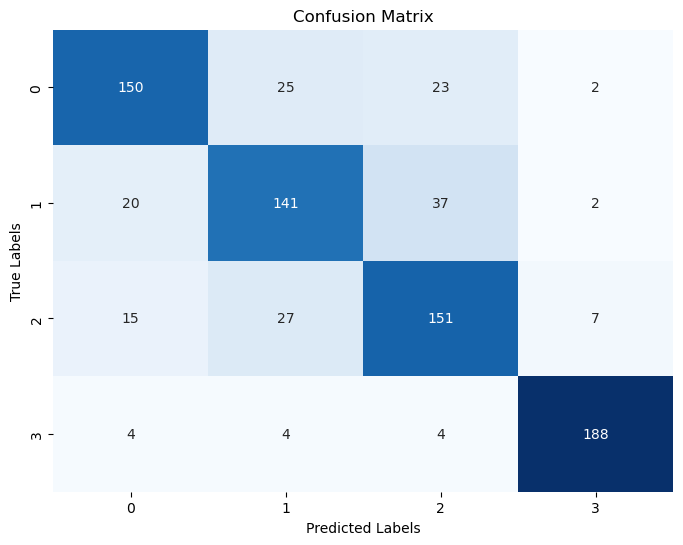

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Doğrulama (veya test) seti üzerinde performans kontrolü
model2.eval()  # Modeli değerlendirme moduna geçiriyoruz
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in val_loader:  # val_loader yerine test_loader kullanılabilir
        images, labels = images.to(device), labels.to(device)
        outputs = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        
        # Gerçek etiketleri ve tahminleri listelere ekleyelim
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Accuracy, precision, recall, F1 score ve confusion matrix'i hesaplayalım
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_preds)
classification_rep = classification_report(all_labels, all_preds)

# ROC AUC score hesaplaması sadece binary sınıflandırma için geçerlidir
if len(set(all_labels)) == 2:
    roc_auc = roc_auc_score(all_labels, all_preds)
    print(f'ROC AUC Score: {roc_auc:.4f}')

# Sonuçları yazdır
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_rep}')

# Confusion matrixi renkli olarak gösterelim
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=range(conf_matrix.shape[1]), yticklabels=range(conf_matrix.shape[0]))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Train Batch size: torch.Size([32, 3, 256, 256])


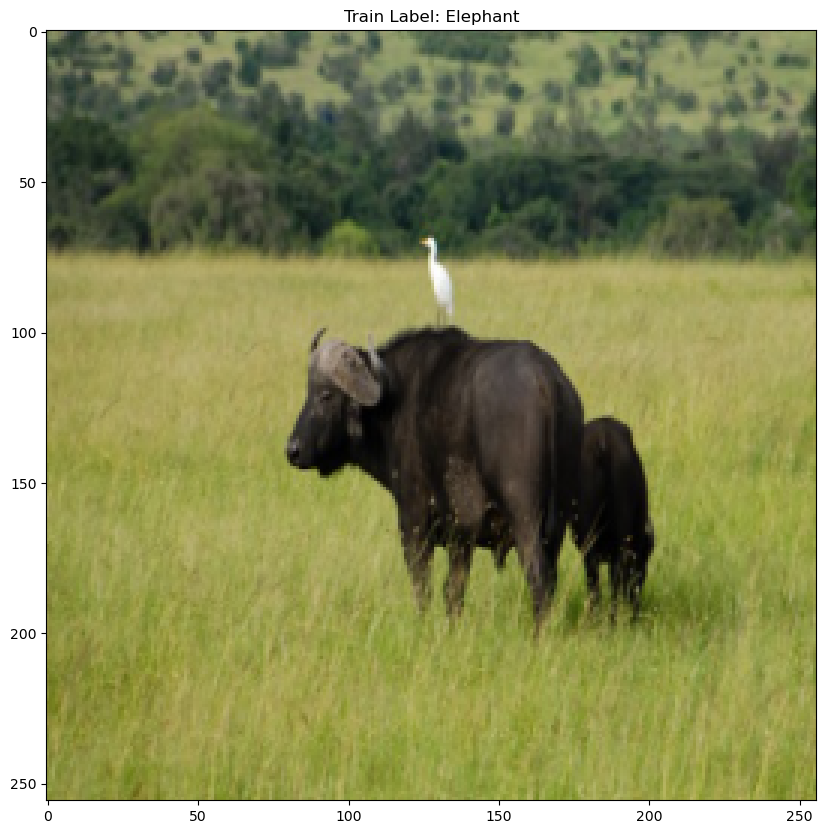

Test Batch size: torch.Size([32, 3, 256, 256])


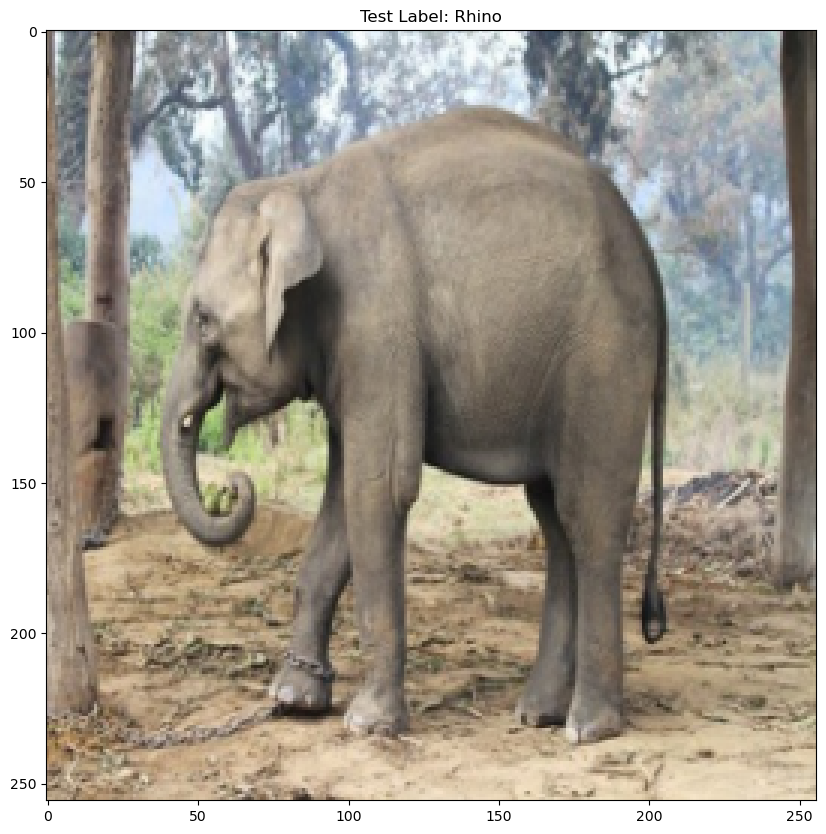

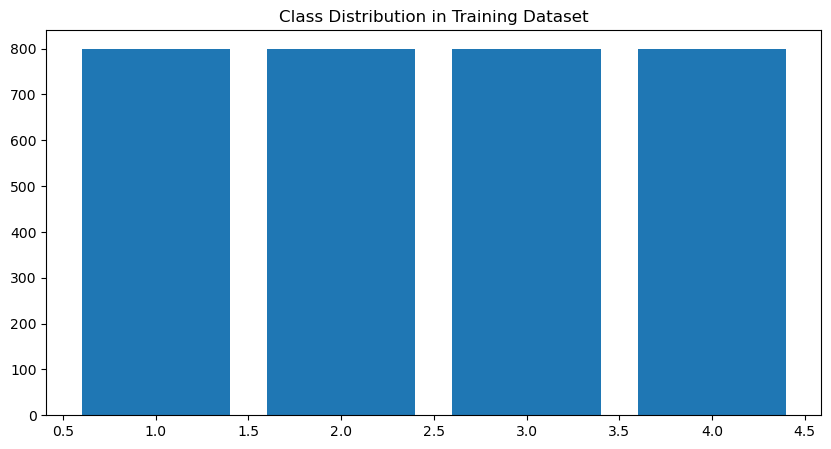

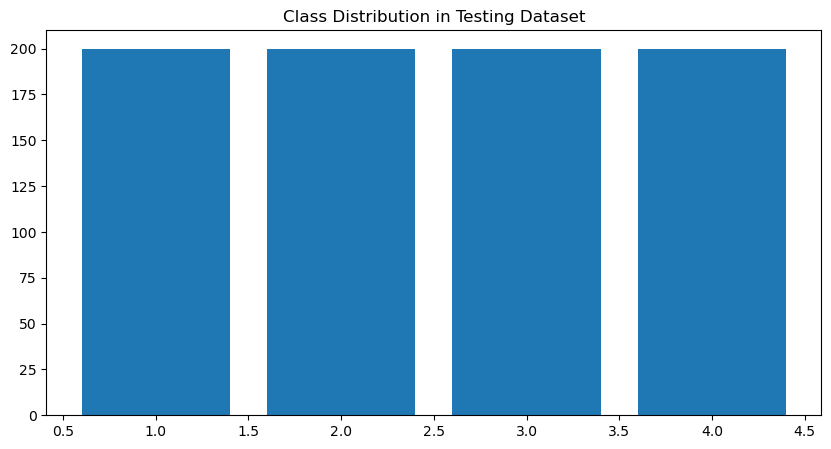

In [159]:
'''
import os
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.transforms import Resize, Compose, Normalize
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter

class CustomImageDataset(Dataset):
    def __init__(self, image_paths, img_labels, classes, transform=None):
        self.image_paths = image_paths
        self.img_labels = img_labels
        self.classes = classes
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = read_image(img_path).float() / 255.0  # Convert image from uint8 to float and normalize to [0, 1]
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

    def get_class_name(self, label):
        return self.classes[label]

def load_image_paths_and_labels(img_dir):
    image_paths = []
    img_labels = []
    classes = []

    valid_extensions = ('.jpg', '.jpeg', '.png')  # Define valid extensions

    # List each subdirectory (category) and each image within it
    for label, sub_dir in enumerate(sorted(os.listdir(img_dir))):
        sub_dir_path = os.path.join(img_dir, sub_dir)
        if os.path.isdir(sub_dir_path):
            classes.append(sub_dir)
            for img_file in os.listdir(sub_dir_path):
                img_path = os.path.join(sub_dir_path, img_file)
                if img_file.lower().endswith(valid_extensions):  # Only add files with valid extensions
                    image_paths.append(img_path)
                    img_labels.append(label)

    return image_paths, img_labels, classes

# Define transforms: Resize and normalize
transform = Compose([
    Resize((256, 256)),  # Resize images to 256x256
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize (ImageNet values)
])

# Load the dataset with all animal classes
dataset_dir = '/Users/mehdiarat/Downloads/archive/animal_computer_vision/Dataset'
image_paths, img_labels, classes = load_image_paths_and_labels(dataset_dir)

# Split the dataset into training and testing sets (80% train, 20% test)
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, img_labels, test_size=0.2, stratify=img_labels, random_state=42
)

# Create training and testing datasets
train_dataset = CustomImageDataset(train_paths, train_labels, classes, transform=transform)
test_dataset = CustomImageDataset(test_paths, test_labels, classes, transform=transform)

# Load datasets using DataLoader
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Define function to unnormalize images
def unnormalize(image, mean, std):
    mean = torch.tensor(mean).view(-1, 1, 1)
    std = torch.tensor(std).view(-1, 1, 1)
    return image * std + mean

# Fetch a batch of training data
train_images, train_labels_batch = next(iter(train_dataloader))
print(f"Train Batch size: {train_images.size()}")

# Unnormalize and visualize a sample training image and label
unnorm_image = unnormalize(train_images[0], mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
plt.figure(figsize=(10, 10))
plt.imshow(unnorm_image.permute(1, 2, 0).numpy())  # Convert image format to (H, W, C)
plt.title(f"Train Label: {train_dataset.get_class_name(train_labels_batch[0].item())}")
plt.show()

# Fetch a batch of testing data
test_images, test_labels_batch = next(iter(test_dataloader))
print(f"Test Batch size: {test_images.size()}")

# Unnormalize and visualize a sample testing image and label
unnorm_image = unnormalize(test_images[0], mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
plt.figure(figsize=(10, 10))
plt.imshow(unnorm_image.permute(1, 2, 0).numpy())  # Convert image format to (H, W, C)
plt.title(f"Test Label: {test_dataset.get_class_name(test_labels_batch[0].item())}")
plt.show()

# Visualize class distribution in the training dataset
train_labels_counter = Counter(train_labels)
plt.figure(figsize=(10, 5))
plt.bar(train_labels_counter.keys(), train_labels_counter.values())
plt.title("Class Distribution in Training Dataset")
plt.show()

# Visualize class distribution in the testing dataset
test_labels_counter = Counter(test_labels)
plt.figure(figsize=(10, 5))
plt.bar(test_labels_counter.keys(), test_labels_counter.values())
plt.title("Class Distribution in Testing Dataset")
plt.show()

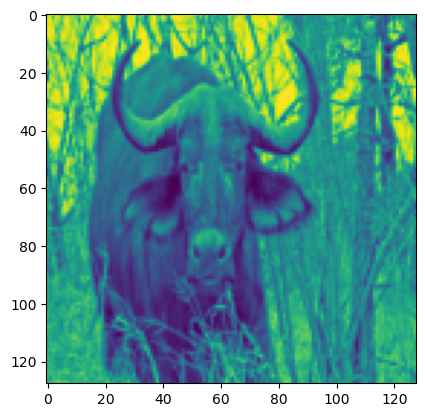

In [176]:
plt.imshow(train_dataset[0][0][0])

In [152]:
train_dataset[0][0]

tensor([[[ 0.8104,  0.8104,  0.8104,  ...,  0.9132,  0.9132,  0.9132],
         [ 0.8104,  0.8104,  0.8104,  ...,  0.9132,  0.9132,  0.9132],
         [ 0.8104,  0.8104,  0.8104,  ...,  0.9132,  0.9132,  0.9132],
         ...,
         [-1.0519, -1.0515, -0.9241,  ..., -1.2197, -1.4899, -1.3525],
         [-1.0958, -1.0751, -1.0842,  ..., -1.2789, -1.4396, -1.2677],
         [-1.1429, -1.1171, -1.1827,  ..., -1.3174, -1.3969, -1.1607]],

        [[ 0.9755,  0.9755,  0.9755,  ...,  1.0805,  1.0805,  1.0805],
         [ 0.9755,  0.9755,  0.9755,  ...,  1.0805,  1.0805,  1.0805],
         [ 0.9755,  0.9755,  0.9755,  ...,  1.0805,  1.0805,  1.0805],
         ...,
         [-1.3440, -1.3046, -1.1214,  ..., -1.5228, -1.6980, -1.4772],
         [-1.3254, -1.2578, -1.2252,  ..., -1.5792, -1.6459, -1.3905],
         [-1.3317, -1.2729, -1.2878,  ..., -1.6046, -1.5975, -1.2745]],

        [[ 1.2805,  1.2805,  1.2805,  ...,  1.3328,  1.3328,  1.3328],
         [ 1.2805,  1.2805,  1.2805,  ...,  1

In [167]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [190]:
import torch.nn as nn

class DeepNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.deep_stack = nn.Sequential(
            # İlk katman
            nn.Linear(256*256*3, 2048), 
            nn.BatchNorm1d(2048),       
            nn.ReLU(),
            nn.Dropout(0.5),

         
            nn.Linear(2048, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(0.5),

       
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),

           
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),

        
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),

            
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),

         
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),

          
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),

        
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.5),

       
        
            nn.Linear(64, 4)  # Son katman, 10 sınıf çıkışı
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.deep_stack(x)
        return logits

In [191]:
model = DeepNeuralNetwork().to(device)
print(model)

DeepNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (deep_stack): Sequential(
    (0): Linear(in_features=196608, out_features=2048, bias=True)
    (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=2048, out_features=2048, bias=True)
    (5): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=2048, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=1024, out_features=1024, bias=True)
    (13): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.5, inplace=False)
    (16): Linear(in_features=1024, out_features=512, bias=T

**Custom Model ile**

In [23]:
class VisualCNN(nn.Module):
    def __init__(self):
        super(VisualCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        
        # Geçici bir tensor kullanarak boyutları otomatik olarak hesaplayalım
        self._to_linear = None
        self.convs(torch.randn(1, 3, 224, 224))
        
        self.fc1 = nn.Linear(self._to_linear, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def convs(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        
        if self._to_linear is None:
            self._to_linear = x.shape[1] * x.shape[2] * x.shape[3]
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

    def visualize_feature_maps(self, feature_maps):
        for idx, feature_map in enumerate(feature_maps):
            plt.figure(figsize=(20, 17))
            for i in range(min(feature_map.shape[1], 8)):
                plt.subplot(1, 8, i+1)
                plt.imshow(feature_map[0, i].detach().cpu().numpy(), cmap='gray')
                plt.axis('off')
            plt.show()

# Modeli cihaza taşıyın ve model3 olarak isimlendirin
model3 = VisualCNN().to(device)

In [24]:
import torch.optim as optim

# Modelin eğitim fonksiyonu
def trainvisual(model, train_loader, criterion, optimizer, device):
    model.train()  # Modeli eğitim moduna geçirme
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()  # Optimizasyon adımını sıfırlama

        # İleri geçiş
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Geri yayılım ve optimizasyon
        loss.backward()
        optimizer.step()

        # İstatistikleri toplama
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

# Doğrulama fonksiyonu
def validatevisual(model, val_loader, criterion, device):
    model.eval()  # Modeli değerlendirme moduna geçirme
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Doğrulamada gradient hesaplamayı kapatma
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

In [10]:
import torch.optim as optim

class VisualCNN(nn.Module):
    def __init__(self):
        super(VisualCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        
        # Geçici bir tensor kullanarak boyutları otomatik olarak hesaplayalım
        self._to_linear = None
        self.convs(torch.randn(1, 3, 224, 224))  # Girdi boyutunu güncelledik
        
        self.fc1 = nn.Linear(self._to_linear, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        # Feature map'leri başlatıyoruz
        self.feature_map1 = None
        self.feature_map2 = None
        self.feature_map3 = None
        self.feature_map4 = None

    def convs(self, x):
        x = self.conv1(x)
        self.feature_map1 = x
        x = self.pool(x)
        self.feature_map2 = x
        x = self.conv2(x)
        self.feature_map3 = x
        x = self.pool(x)
        self.feature_map4 = x
        
        if self._to_linear is None:
            self._to_linear = x.shape[1] * x.shape[2] * x.shape[3]
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

    def visualize_feature_maps(self, feature_maps):
        for idx, feature_map in enumerate(feature_maps):
            plt.figure(figsize=(20, 17))
            for i in range(min(feature_map.shape[1], 8)):  # İlk 8 filtreyi görselleştir
                plt.subplot(1, 8, i+1)
                plt.imshow(feature_map[0, i].detach().cpu().numpy(), cmap='gray')
                plt.axis('off')
            plt.suptitle(f'Feature Maps from Layer {idx+1}', fontsize=16)
            plt.show()

# Modeli cihaza taşıyın
model3 = VisualCNN().to(device)

# Kayıp fonksiyonu ve optimizasyon
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model3.parameters(), lr=0.001)

# Epoch sayısı
num_epochs = 20

# Eğitim ve doğrulama seti için DataLoader'lar
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Eğitim döngüsü
for epoch in range(num_epochs):
    model3.train()  # Modeli eğitim moduna geçirin
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()  # Optimizasyon adımını sıfırlama

        # İleri geçiş
        outputs = model3(inputs)
        loss = criterion(outputs, labels)

        # Geri yayılım ve optimizasyon
        loss.backward()
        optimizer.step()

        # İstatistikleri toplama
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Her batch için ilk görüntüyü görselleştirme
        model3.eval()  # Modeli değerlendirme moduna geçirin
        '''
        with torch.no_grad():
            # Batch'teki ilk görüntüyü alın
            input_image = inputs[0].unsqueeze(0)  # Batch boyutunu koruyun
            
            # Modeli çalıştırın (bu aynı zamanda feature map'leri güncelleyecek)
            output = model3(input_image)
        
            # Conv1, Pool1, Conv2, Pool2 katmanlarındaki feature map'leri görselleştirin
            print(f'Visualizing feature maps for Batch {batch_idx+1} of Epoch {epoch+1}')
            model3.visualize_feature_maps([
                model3.feature_map1,
                model3.feature_map2,
                model3.feature_map3,
                model3.feature_map4
            ])'''

        model3.train()  # Modeli tekrar eğitim moduna alın

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}')

Epoch 1/20
Train Loss: 1.8909, Train Acc: 0.3494
Epoch 2/20
Train Loss: 1.1449, Train Acc: 0.4863
Epoch 3/20
Train Loss: 1.1122, Train Acc: 0.5000
Epoch 4/20
Train Loss: 1.0752, Train Acc: 0.5284
Epoch 5/20
Train Loss: 1.0888, Train Acc: 0.5275
Epoch 6/20
Train Loss: 1.0647, Train Acc: 0.5375
Epoch 7/20
Train Loss: 1.0647, Train Acc: 0.5450
Epoch 8/20
Train Loss: 1.0805, Train Acc: 0.5256
Epoch 9/20
Train Loss: 1.0691, Train Acc: 0.5366
Epoch 10/20
Train Loss: 1.0482, Train Acc: 0.5419
Epoch 11/20
Train Loss: 1.0551, Train Acc: 0.5500
Epoch 12/20
Train Loss: 1.0214, Train Acc: 0.5681
Epoch 13/20
Train Loss: 1.0350, Train Acc: 0.5575
Epoch 14/20
Train Loss: 1.0236, Train Acc: 0.5597
Epoch 15/20
Train Loss: 1.0382, Train Acc: 0.5563
Epoch 16/20
Train Loss: 1.0165, Train Acc: 0.5684
Epoch 17/20
Train Loss: 1.0419, Train Acc: 0.5650
Epoch 18/20
Train Loss: 1.0446, Train Acc: 0.5575
Epoch 19/20
Train Loss: 1.0382, Train Acc: 0.5594
Epoch 20/20
Train Loss: 1.0001, Train Acc: 0.5719


###***Resnet ile***

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Cihazı kontrol etme
device = torch.device("mps" if torch.backends.mps.is_built() else "cpu")

# ResNet18 modelini yükleme ve sınıf sayısını ayarlama
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
num_classes = len(dataset.classes)  # Veri setindeki sınıf sayısını al
model.fc = nn.Linear(num_features, num_classes)

# Modeli cihaza taşıma
model = model.to(device)

# Kayıp ve optimizasyon fonksiyonunu tanımlama
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Eğitim fonksiyonu
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, labels) in enumerate(train_loader, 1):  # batch_idx ekledik
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Optimizasyonu sıfırlama
        optimizer.zero_grad()

        # İleri geçiş
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Geri yayılım
        loss.backward()
        optimizer.step()

        # İstatistikleri toplama
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Batch doğruluğunu hesapla ve yazdır
        batch_acc = (predicted == labels).sum().item() / labels.size(0)
        print(f'Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}, Accuracy: {batch_acc:.4f}')

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

# Doğrulama fonksiyonu
def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

# Eğitim döngüsünü çalıştırma
num_epochs = 25

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

Epoch 1/25
Batch 1/25, Loss: 1.7079, Accuracy: 0.1641
Batch 2/25, Loss: 0.3754, Accuracy: 0.8906
Batch 3/25, Loss: 0.4085, Accuracy: 0.8516
Batch 4/25, Loss: 0.3686, Accuracy: 0.8672
Batch 5/25, Loss: 0.4835, Accuracy: 0.8125
Batch 6/25, Loss: 0.5334, Accuracy: 0.7734
Batch 7/25, Loss: 0.6189, Accuracy: 0.7969
Batch 8/25, Loss: 0.4801, Accuracy: 0.8516
Batch 9/25, Loss: 0.4189, Accuracy: 0.8125
Batch 10/25, Loss: 0.4401, Accuracy: 0.8516
Batch 11/25, Loss: 0.3612, Accuracy: 0.8750
Batch 12/25, Loss: 0.3707, Accuracy: 0.8672
Batch 13/25, Loss: 0.3499, Accuracy: 0.8672
Batch 14/25, Loss: 0.3952, Accuracy: 0.8047
Batch 15/25, Loss: 0.3233, Accuracy: 0.8828
Batch 16/25, Loss: 0.3518, Accuracy: 0.8516
Batch 17/25, Loss: 0.3960, Accuracy: 0.8281
Batch 18/25, Loss: 0.4177, Accuracy: 0.8359
Batch 19/25, Loss: 0.2716, Accuracy: 0.8984
Batch 20/25, Loss: 0.3862, Accuracy: 0.8203
Batch 21/25, Loss: 0.2675, Accuracy: 0.8984
Batch 22/25, Loss: 0.2554, Accuracy: 0.9062
Batch 23/25, Loss: 0.2430, Acc

Batch 1/25, Loss: 0.2066, Accuracy: 0.9219
Batch 2/25, Loss: 0.1668, Accuracy: 0.9453
Batch 3/25, Loss: 0.1463, Accuracy: 0.9375
Batch 4/25, Loss: 0.1217, Accuracy: 0.9531
Batch 5/25, Loss: 0.1349, Accuracy: 0.9453
Batch 6/25, Loss: 0.1687, Accuracy: 0.9375
Batch 7/25, Loss: 0.1279, Accuracy: 0.9375
Batch 8/25, Loss: 0.1169, Accuracy: 0.9453
Batch 9/25, Loss: 0.1383, Accuracy: 0.9375
Batch 10/25, Loss: 0.2626, Accuracy: 0.9219
Batch 11/25, Loss: 0.1443, Accuracy: 0.9375
Batch 12/25, Loss: 0.1077, Accuracy: 0.9609
Batch 13/25, Loss: 0.1272, Accuracy: 0.9688
Batch 14/25, Loss: 0.2504, Accuracy: 0.9297
Batch 15/25, Loss: 0.1039, Accuracy: 0.9531
Batch 16/25, Loss: 0.1204, Accuracy: 0.9688
Batch 17/25, Loss: 0.0979, Accuracy: 0.9844
Batch 18/25, Loss: 0.2596, Accuracy: 0.9141
Batch 19/25, Loss: 0.1482, Accuracy: 0.9375
Batch 20/25, Loss: 0.2591, Accuracy: 0.9141
Batch 21/25, Loss: 0.2860, Accuracy: 0.8906
Batch 22/25, Loss: 0.1303, Accuracy: 0.9375
Batch 23/25, Loss: 0.2836, Accuracy: 0.90

Batch 1/25, Loss: 0.0645, Accuracy: 0.9922
Batch 2/25, Loss: 0.2138, Accuracy: 0.9141
Batch 3/25, Loss: 0.1445, Accuracy: 0.9375
Batch 4/25, Loss: 0.2396, Accuracy: 0.8906
Batch 5/25, Loss: 0.1565, Accuracy: 0.9453
Batch 6/25, Loss: 0.2255, Accuracy: 0.9062
Batch 7/25, Loss: 0.1205, Accuracy: 0.9688
Batch 8/25, Loss: 0.1551, Accuracy: 0.9375
Batch 9/25, Loss: 0.1180, Accuracy: 0.9688
Batch 10/25, Loss: 0.1303, Accuracy: 0.9531
Batch 11/25, Loss: 0.1570, Accuracy: 0.9531
Batch 12/25, Loss: 0.2192, Accuracy: 0.9141
Batch 13/25, Loss: 0.1516, Accuracy: 0.9453
Batch 14/25, Loss: 0.1058, Accuracy: 0.9531
Batch 15/25, Loss: 0.1041, Accuracy: 0.9766
Batch 16/25, Loss: 0.0970, Accuracy: 0.9609
Batch 17/25, Loss: 0.1207, Accuracy: 0.9688
Batch 18/25, Loss: 0.1884, Accuracy: 0.9297
Batch 19/25, Loss: 0.1046, Accuracy: 0.9688
Batch 20/25, Loss: 0.0975, Accuracy: 0.9531
Batch 21/25, Loss: 0.1099, Accuracy: 0.9609
Batch 22/25, Loss: 0.1357, Accuracy: 0.9453
Batch 23/25, Loss: 0.1003, Accuracy: 0.96

Batch 1/25, Loss: 0.0908, Accuracy: 0.9688
Batch 2/25, Loss: 0.1337, Accuracy: 0.9531
Batch 3/25, Loss: 0.0939, Accuracy: 0.9688
Batch 4/25, Loss: 0.0922, Accuracy: 0.9609
Batch 5/25, Loss: 0.1350, Accuracy: 0.9609
Batch 6/25, Loss: 0.1534, Accuracy: 0.9609
Batch 7/25, Loss: 0.2002, Accuracy: 0.9297
Batch 8/25, Loss: 0.0805, Accuracy: 0.9688
Batch 9/25, Loss: 0.0970, Accuracy: 0.9688
Batch 10/25, Loss: 0.1374, Accuracy: 0.9453
Batch 11/25, Loss: 0.2208, Accuracy: 0.9062
Batch 12/25, Loss: 0.1165, Accuracy: 0.9688
Batch 13/25, Loss: 0.1170, Accuracy: 0.9453
Batch 14/25, Loss: 0.1250, Accuracy: 0.9531
Batch 15/25, Loss: 0.1252, Accuracy: 0.9531
Batch 16/25, Loss: 0.1054, Accuracy: 0.9609
Batch 17/25, Loss: 0.1348, Accuracy: 0.9375
Batch 18/25, Loss: 0.1094, Accuracy: 0.9453
Batch 19/25, Loss: 0.1467, Accuracy: 0.9375
Batch 20/25, Loss: 0.1059, Accuracy: 0.9609
Batch 21/25, Loss: 0.1401, Accuracy: 0.9375
Batch 22/25, Loss: 0.1368, Accuracy: 0.9375
Batch 23/25, Loss: 0.1081, Accuracy: 0.95

In [12]:
learning_rate = 1e-3
batch_size = 128
epochs = 500

In [16]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Verileri MPS cihazına taşı
        X, y = X.to(device), y.to(device)

        # Tahmin yap ve kaybı hesapla
        pred = model(X)
        loss = loss_fn(pred, y)

        # Geriye yayılım
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Her batch'te kaybı ve ilerlemeyi göster
        loss, current = loss.item(), batch * len(X)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            # Verileri MPS cihazına taşı ve float'a dönüştür
            X, y = X.to(device).float(), y.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    
    
    num_epochs = 10

for epoch in range(num_epochs):
    train_loss, train_acc = train_loop(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

Epoch 1/20
Train Loss: 0.4120, Train Acc: 0.8397
Val Loss: 1.6714, Val Acc: 0.6663
Epoch 2/20
Train Loss: 0.2422, Train Acc: 0.9087
Val Loss: 0.2675, Val Acc: 0.9038
Epoch 3/20
Train Loss: 0.1998, Train Acc: 0.9234
Val Loss: 0.2552, Val Acc: 0.8888
Epoch 4/20
Train Loss: 0.2154, Train Acc: 0.9169
Val Loss: 0.3060, Val Acc: 0.8825


KeyboardInterrupt: 

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim

# Check if MPS is available and set it as the device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Initialize your model
model = DeepNeuralNetwork()

# Move model to MPS device
model.to(device)

# Set up loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-4)

# Number of epochs to train
epochs = 10

# Training loop
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)

print("Done!")

NameError: name 'DeepNeuralNetwork' is not defined

In [144]:
import os
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.io import read_image
from torchvision.transforms import Resize
import torch
import matplotlib.pyplot as plt

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_labels = []
        self.image_paths = []

        # Klasördeki her bir alt klasörü (kategori) ve bu klasördeki her bir görüntüyü listele
        for label, sub_dir in enumerate(os.listdir(img_dir)):
            sub_dir_path = os.path.join(img_dir, sub_dir)
            if os.path.isdir(sub_dir_path):
                for img_file in os.listdir(sub_dir_path):
                    img_path = os.path.join(sub_dir_path, img_file)
                    # Geçici ve gizli dosyaları filtrele
                    if img_file.endswith(('.png', '.jpg', '.jpeg')) and not img_file.startswith('.'):
                        self.image_paths.append(img_path)
                        self.img_labels.append(label)

        self.classes = os.listdir(img_dir)  # Klasör adlarını sınıf isimleri olarak kaydet

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = read_image(img_path).float()  # Zaten tensöre dönüştürülmüş ve float türüne çevrildi
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

    def get_class_name(self, label):
        return self.classes[label]

# Görüntüleri yeniden boyutlandırmak için transform oluştur
transform = Resize((256, 256))  # Görüntüleri 256x256 boyutuna getir

# Tüm hayvan türlerini içeren veri setini oluştur
full_dataset = CustomImageDataset(
    img_dir='/Users/mehdiarat/Downloads/archive/animal_computer_vision/Dataset', 
    transform=transform
)

# Veri setini eğitim ve test olarak ayır (80% train, 20% test)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

# Dataloader ile veri setlerini yükle
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# Modeli MPS'e taşıyın
model = NeuralNetwork().to(device)

# Eğitim döngüsü
epochs = 10
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Verileri MPS cihazına taşı
        X, y = X.to(device), y.to(device)

        # Tahmin yap ve kaybı hesapla
        pred = model(X)
        loss = loss_fn(pred, y)

        # Geriye yayılım
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            # Verileri MPS cihazına taşı
            X, y = X.to(device), y.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)

print("Done!")

Epoch 1
-------------------------------
loss: 11.926019  [    0/ 3200]
Test Error: 
 Accuracy: 24.9%, Avg loss: 2.424724 

Epoch 2
-------------------------------
loss: 2.251142  [    0/ 3200]


KeyboardInterrupt: 